<a href="https://colab.research.google.com/github/sakurasakura1996/Pytorch-start-learning/blob/master/Dive_into_DL_Pytorch_5_9_GOOGLENET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5.9 含并行连结的网络 GoogleNet
2014年的ImageNet识别大赛上，GoogleNet网络结构大放异彩。他虽然在名字上想LeNet致敬，但在网络结构上已经很难看到LeNet影子。GoogleNet吸收了NiN网络串联网络的思想，并在此基础上做了很大改进。这里介绍的是第一个版本的GoogleNet
## 5.9.1 Inception块
GoogleNet中的基础卷积块叫做inception块，得名于盗梦空间Inception。这个基础块结构如下图：
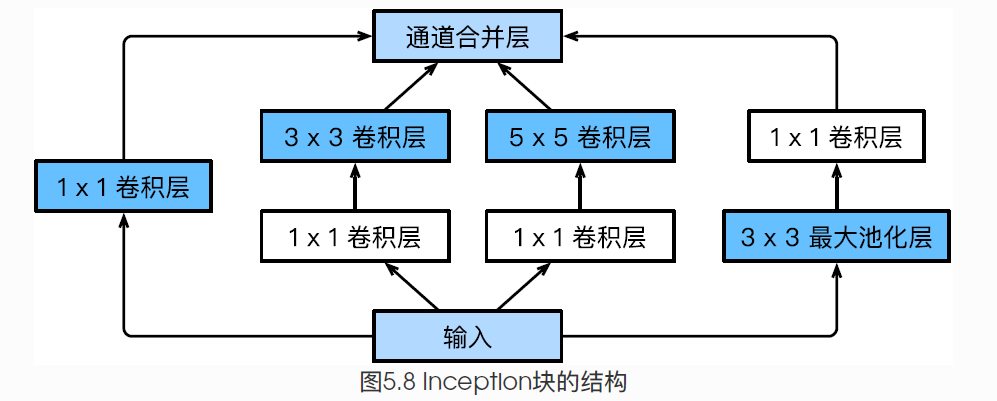
Inception块里有四条并行的线路。前3条线路使用窗口大小分别是1x1，3x3，5x5 的卷积层来抽取不同空间尺寸下的信息，中间两个线路会对输入先做1x1卷积来减少输入通道数，以降低模型复杂度。第四条线路则使用3x3最大池化层，后接1x1卷积层来改变通道数。4条线路都是用了合适的填充来时输入与输出的高和宽一致。最后将每条线路的输出在通道维上连结，并输入到接下来的层中去。

In [0]:
# Inception块中可以自定义的超参数是每个层的输出通道数，我们以此来控制模型复杂度
import time
import torch
from torch import nn, optim
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Inception(nn.Module):
  # c1 - c4为每条线路里的层的输出通道
  def __init__(self,in_c, c1, c2, c3, c4):
    super(Inception, self).__init__()
    # 线路1，单1x1卷积层
    self.p1_1 = nn.Conv2d(in_c, c1, kernel_size=1)

    # 线路2， 1x1卷积层后接 3x3卷积层
    self.p2_1 = nn.Conv2d(in_c, c2[0], kernel_size=1)
    self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)

    # 线路3，1x1卷积层后接5x5卷积层
    self.p3_1 = nn.Conv2d(in_c,c3[0],kernel_size=1)
    self.p3_2 = nn.Conv2d(c3[0],c3[1],kernel_size=5,padding=2)

    # 线路4，3x3最大池化层后接 1x1卷积层
    self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    self.p4_2 = nn.Conv2d(in_c, c4, kernel_size=1)
  
  def forward(self, x):
    p1 = F.relu(self.p1_1(x))
    p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
    p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
    p4 = F.relu(self.p4_2(self.p4_1(x)))
    return torch.cat((p1, p2, p3, p4),dim=1) # 在通道维上连结输出


In [0]:
# 5.9.2 GoogleNet模型
# Googlenet跟VGG一样，在主体卷积部分中使用5个模块（block），每个模块之间使用步幅为2的3x3最大池化层来减小输出高宽。第一模块使用一个64通道的7x7卷积层
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [0]:
# 第二个模块使用2个卷积层:首先是64通道的1x1卷积层，然后是将通道增大3倍的3x3卷积层。他对应Inception的第二条线路
b2 = nn.Sequential(
    nn.Conv2d(64, 64, kernel_size=1),
    nn.Conv2d(64, 192, kernel_size=3, padding=1),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [0]:
# 第三个模块串联2个完整的Inception块。第一个Inception的输出通道数为 64+128+32+32 = 256.其中4条线路的输出通道数比例为
# 64:128:32:32 = 2:4:1:1 
b3 = nn.Sequential(
    Inception(192, 64, (96, 128), (16, 32), 32),
    Inception(256, 128, (128, 192), (32, 96), 64),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [0]:
# 第四模块更复杂
b4 = nn.Sequential(
    Inception(480, 192, (96, 208), (16, 48), 64),
    Inception(512, 160, (112, 224), (24, 64), 64),
    Inception(512, 128, (128, 256), (24, 64), 64),
    Inception(512, 112, (144, 288), (32, 64), 64),
    Inception(528, 256, (160, 320), (32, 128), 128),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [0]:
# 第五模块
class FlattenLayer(nn.Module):
  def __init__(self):
    super(FlattenLayer, self).__init__()
  def forward(self, x): # x shape: (batch, *, *, ...)
    return x.view(x.shape[0], -1)


class GlobalAvgPool2d(nn.Module):
  # 全局平均池化层可通过将池化窗口形状设置成输入的高和宽实现
  def __init__(self):
    super(GlobalAvgPool2d,self).__init__()
  def forward(self, x):
    return F.avg_pool2d(x, kernel_size=x.size()[2:])

b5 = nn.Sequential(
    Inception(832, 256, (160, 320), (32, 128), 128),
    Inception(832, 384, (192, 384), (48, 128), 128),
    GlobalAvgPool2d()
)

In [116]:
net = nn.Sequential(
    b1, b2, b3, b4, b5, FlattenLayer(), nn.Linear(1024, 10)
)

print(net)

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Inception(
      (p1_1): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (p2_1): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (p2_2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (p3_1): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (p3_2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (p4_1): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (p4_2): Conv2d(192, 32, kernel_size=(1, 1), stride=(1, 1))


In [117]:
# GoogleNet 模型的计算复杂，而且不如Vgg那样便于修改通道数，本节里我们将输入的高和宽从224降到96来简化计算。下面演示各个模块之间的形状变化
X = torch.rand(1,1,96,96)
for blk in net.children():
  X = blk(X)
  print('output shape: ',X.shape)
  

output shape:  torch.Size([1, 64, 24, 24])
output shape:  torch.Size([1, 192, 12, 12])
output shape:  torch.Size([1, 480, 6, 6])
output shape:  torch.Size([1, 832, 3, 3])
output shape:  torch.Size([1, 1024, 1, 1])
output shape:  torch.Size([1, 1024])
output shape:  torch.Size([1, 10])


In [0]:
# 5.9.3 获取模型和训练模型
import torchvision

def load_data_fashion_mnist(batch_size,resize=None):
  trans = []
  if resize:
    trans.append(torchvision.transforms.Resize(size=resize))
  trans.append(torchvision.transforms.ToTensor())

  transform = torchvision.transforms.Compose(trans)
  mnist_train = torchvision.datasets.FashionMNIST(root='~/root/Datasets/FashionMNIST',train=True,download=True,transform=transform)
  mnist_test = torchvision.datasets.FashionMNIST(root='~/root/Datasets/FashionMNIST',train=False,download=True,transform=transform)

  train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size,shuffle=True,num_workers=4)
  test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size,shuffle=False,num_workers=4)
  return train_iter, test_iter
    


In [0]:
def evaluate_accuracy(data_iter, net, device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
  acc_sum, n =0.0, 0
  with torch.no_grad():
    for X,y in data_iter:
      if isinstance(net, torch.nn.Module):
        net.eval()   # 评估模式，这回关闭dropout
        acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
        net.train()  # 改回训练模式
      else:
        if('is_training' in net.__code__.co_varnames):
          acc_sum += (net(X,is_training=False).argmax(dim=1) == y).float().sum().item()
        else:
          acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
      n += y.shape[0]
  return acc_sum / n

In [0]:
import time
def train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs):
  net = net.to(device)
  print("training on ",device)
  loss = torch.nn.CrossEntropyLoss()
  batch_count = 0
  for epoch in range(num_epochs):
    train_acc_sum, train_l_sum, n, start = 0.0, 0.0, 0, time.time()
    for X, y in train_iter:
      X = X.to(device)
      y = y.to(device)
      y_hat = net(X)
      l = loss(y_hat,y)
      optimizer.zero_grad()
      l.backward()
      optimizer.step()
      train_l_sum += l.cpu().item()   # 这里应该是可以节省gpu空间吧
      train_acc_sum += (y_hat.argmax(dim=1)==y).sum().cpu().item()
      n += y.shape[0]
      batch_count += 1
    test_acc = evaluate_accuracy(test_iter, net)
    print("epoch: %d, loss: %.4f, train_acc: %.4f, test_acc: %.4f, time: %.1f"%(epoch+1,train_l_sum/batch_count, train_acc_sum/n, test_acc, time.time()-start))

      



In [121]:
batch_size = 128
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=96)
lr = 0.001
num_epochs = 5
optimizer = torch.optim.Adam(net.parameters(),lr=lr)
train_ch5(net,train_iter,test_iter,batch_size=batch_size,num_epochs=num_epochs,optimizer=optimizer,device=device)

training on  cuda
epoch: 1, loss: 0.9647, train_acc: 0.6241, test_acc: 0.7926, time: 136.0
epoch: 2, loss: 0.2125, train_acc: 0.8403, test_acc: 0.8500, time: 136.1
epoch: 3, loss: 0.1168, train_acc: 0.8700, test_acc: 0.8546, time: 136.0
epoch: 4, loss: 0.0780, train_acc: 0.8827, test_acc: 0.8787, time: 135.8
epoch: 5, loss: 0.0584, train_acc: 0.8897, test_acc: 0.8845, time: 136.2
